<hr style="height:2px;">

# Demo: Neural network training for denoising of EM data with Noise2Noise

This notebook demonstrates training a CARE model for a 2D denoising task, assuming that training data was already generated via [1_datagen_SEM.ipynb](1_datagen_SEM.ipynb) and has been saved to disk to the file ``train/my_training_data_n2n.npz``.

Note that training a neural network for actual use should be done on more (representative) data and with more training time.

More documentation is available at http://csbdeep.bioimagecomputing.com/doc/.

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE

2022-07-19 16:35:03.580425: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


The TensorFlow backend uses all available GPU memory by default, hence it can be useful to limit it:

In [ ]:
# limit_gpu_memory(fraction=1/2)

<hr style="height:2px;">

# Training data

Load training data generated via [1_datagen.ipynb](1_datagen.ipynb), use 10% as validation data.

In [2]:
(X,Y), (X_val,Y_val), axes = load_training_data('train/my_training_data_n2n.npz', validation_split=0.1, verbose=True)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

number of training images:	 922
number of validation images:	 102
image size (2D):		 (64, 64)
axes:				 SYXC
channels in / out:		 1 / 1


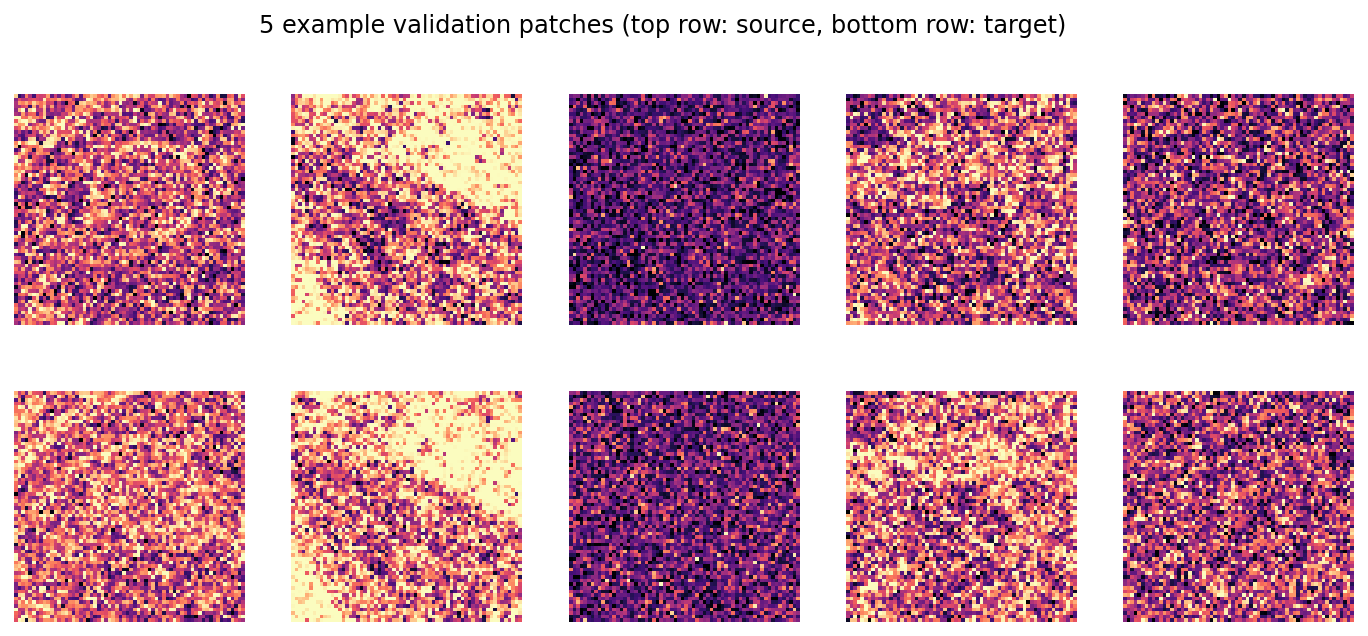

In [3]:
plt.figure(figsize=(12,5))
plot_some(X_val[:5],Y_val[:5])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');

<hr style="height:2px;">

# CARE model

Before we construct the actual CARE model, we have to define its configuration via a `Config` object, which includes 
* parameters of the underlying neural network,
* the learning rate,
* the number of parameter updates per epoch,
* the loss function, and
* whether the model is probabilistic or not.

The defaults should be sensible in many cases, so a change should only be necessary if the training process fails.  

---

<span style="color:red;font-weight:bold;">Important</span>: Note that for this notebook we use a very small number of update steps per epoch for immediate feedback, whereas this number should be increased considerably (e.g. `train_steps_per_epoch=400`) to obtain a well-trained model.

In [4]:
config = Config(axes, n_channel_in, n_channel_out, train_steps_per_epoch=10)
print(config)
vars(config)

Config(axes='YXC', n_channel_in=1, n_channel_out=1, n_dim=2, probabilistic=False, train_batch_size=16, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_epochs=100, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_steps_per_epoch=10, train_tensorboard=True, unet_input_shape=(None, None, 1), unet_kern_size=5, unet_last_activation='linear', unet_n_depth=2, unet_n_first=32, unet_residual=True)


{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'probabilistic': False,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 5,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mae',
 'train_epochs': 100,
 'train_steps_per_epoch': 10,
 'train_learning_rate': 0.0004,
 'train_batch_size': 16,
 'train_tensorboard': True,
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0}}

We now create a CARE model with the chosen configuration:

In [5]:
model = CARE(config, 'my_model_n2n', basedir='models')

2022-07-19 16:40:43.105499: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-07-19 16:40:43.139763: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 16:40:43.140135: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:01.0 name: NVIDIA A40-16Q computeCapability: 8.6
coreClock: 1.74GHz coreCount: 84 deviceMemorySize: 15.82GiB deviceMemoryBandwidth: 648.29GiB/s
2022-07-19 16:40:43.140153: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-07-19 16:40:43.165258: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-07-19 16:40:43.165292: I tensorflow/stream_executor/platform/def

<hr style="height:2px;">

# Training

Training the model will likely take some time. We recommend to monitor the progress with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard) (example below), which allows you to inspect the losses during training.
Furthermore, you can look at the predictions for some of the validation images, which can be helpful to recognize problems early on.

You can start TensorBoard from the current working directory with `tensorboard --logdir=.`
Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.

![](http://csbdeep.bioimagecomputing.com/img/tensorboard_denoising3D.png)

In [6]:
# Start tensorboard
#!tensorboard --logdir=. --port 6006

2022-07-19 12:47:12.186600: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.9.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [6]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

/home/mattia.toninelli/miniconda3/envs/care/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
2022-07-19 16:44:21.720556: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-19 16:44:21.720825: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2949995000 Hz


Epoch 1/100
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x7f7aabc33d40>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names.
Match 0:
(lambda x: K.mean(x, axis=(- 1)))

Match 1:
(lambda x: x)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x7f7aabc33d40>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names.
Match 0:
(lambda x: K.mean(x, axis=(- 1)))

Match 1:
(lambda x: x)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x7f7aabc33ef0>: found multiple de

2022-07-19 16:44:22.301649: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-07-19 16:44:22.697750: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2022-07-19 16:44:23.293965: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-19 16:44:23.293998: W tensorflow/stream_executor/gpu/asm_compiler.cc:56] Couldn't invoke ptxas --version
2022-07-19 16:44:23.294397: E tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-19 16:44:23.294451: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-07-19 16:44:23.705767: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully ope

10/10 [==============================] - 15s 681ms/step - loss: 0.2397 - mse: 0.0949 - mae: 0.2397 - val_loss: 0.2307 - val_mse: 0.0877 - val_mae: 0.2307
Epoch 2/100
10/10 [==============================] - 0s 12ms/step - loss: 0.2239 - mse: 0.0829 - mae: 0.2239 - val_loss: 0.2075 - val_mse: 0.0713 - val_mae: 0.2075
Epoch 3/100
10/10 [==============================] - 0s 12ms/step - loss: 0.2122 - mse: 0.0716 - mae: 0.2122 - val_loss: 0.1975 - val_mse: 0.0636 - val_mae: 0.1975
Epoch 4/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1987 - mse: 0.0636 - mae: 0.1987 - val_loss: 0.1914 - val_mse: 0.0594 - val_mae: 0.1914
Epoch 5/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1909 - mse: 0.0584 - mae: 0.1909 - val_loss: 0.1884 - val_mse: 0.0563 - val_mae: 0.1884
Epoch 6/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1866 - mse: 0.0557 - mae: 0.1866 - val_loss: 0.1859 - val_mse: 0.0556 - val_mae: 0.1859
Epoch 7/100
10/10 [=======

Epoch 51/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1827 - mse: 0.0544 - mae: 0.1827 - val_loss: 0.1805 - val_mse: 0.0531 - val_mae: 0.1805
Epoch 52/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1807 - mse: 0.0535 - mae: 0.1807 - val_loss: 0.1804 - val_mse: 0.0531 - val_mae: 0.1804
Epoch 53/100
10/10 [==============================] - 0s 13ms/step - loss: 0.1807 - mse: 0.0536 - mae: 0.1807 - val_loss: 0.1806 - val_mse: 0.0532 - val_mae: 0.1806
Epoch 54/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1833 - mse: 0.0544 - mae: 0.1833 - val_loss: 0.1803 - val_mse: 0.0531 - val_mae: 0.1803
Epoch 55/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1806 - mse: 0.0534 - mae: 0.1806 - val_loss: 0.1804 - val_mse: 0.0530 - val_mae: 0.1804
Epoch 56/100
10/10 [==============================] - 0s 12ms/step - loss: 0.1834 - mse: 0.0549 - mae: 0.1834 - val_loss: 0.1803 - val_mse: 0.0536 - val_mae: 0.1803
Epoch 57/1

10/10 [==============================] - 0s 13ms/step - loss: 0.1786 - mse: 0.0531 - mae: 0.1786 - val_loss: 0.1799 - val_mse: 0.0533 - val_mae: 0.1799

Loading network weights from 'weights_best.h5'.


## Plot final training history (available in TensorBoard during training):
Why is loss for training set almost always higher than validation? Is it generalizing extremely well? The answer is that in this N2N approach the loss becomes a less trustful metric (the same applies to N2V) where one training vs GT in this case just means something vs something else extremely similar. Therefore, small variations in the composition of the validation set or high homogeneity within it might determine a better performance of the model in this case.

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


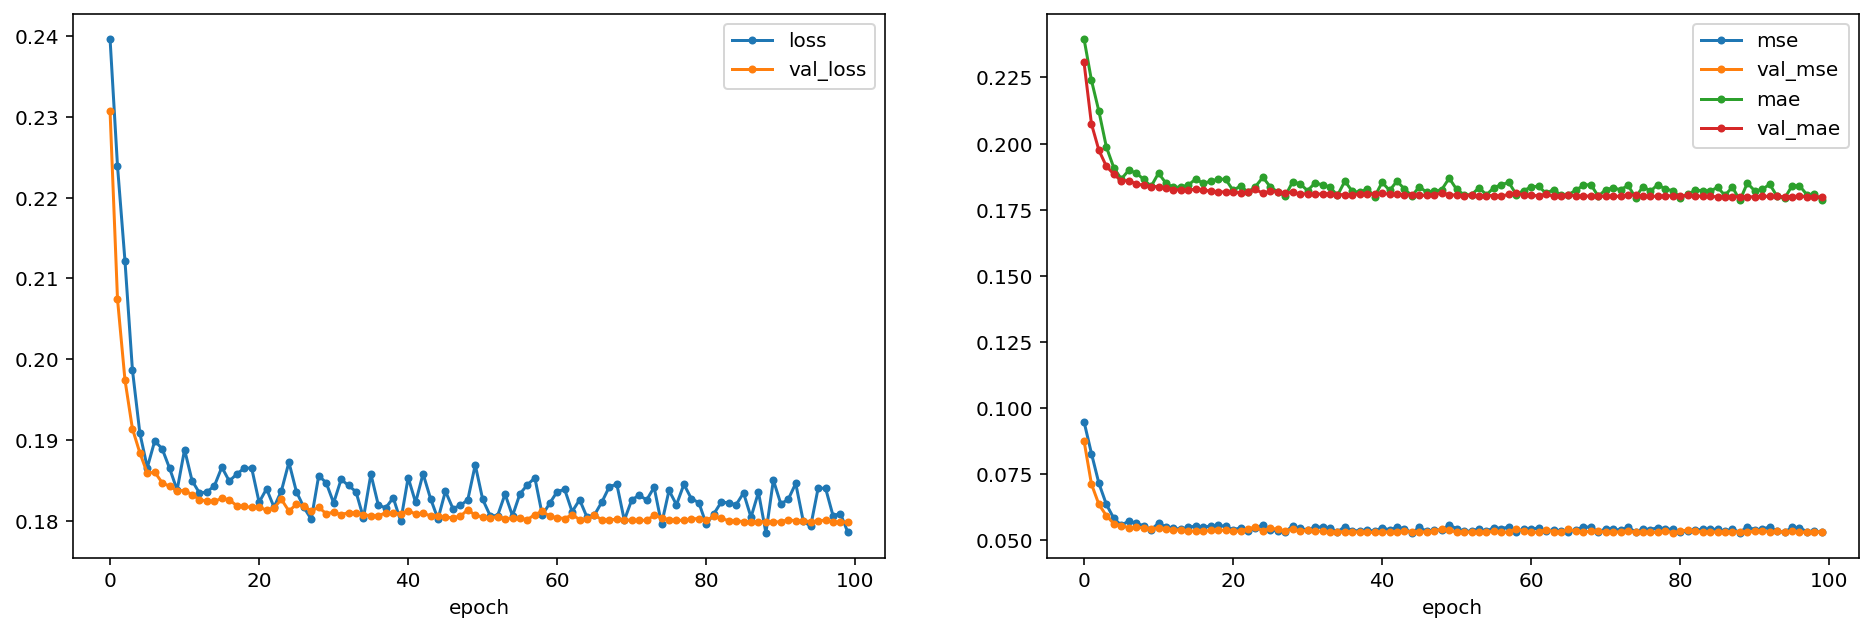

In [7]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

<hr style="height:2px;">

# Evaluation

Example results for validation images.

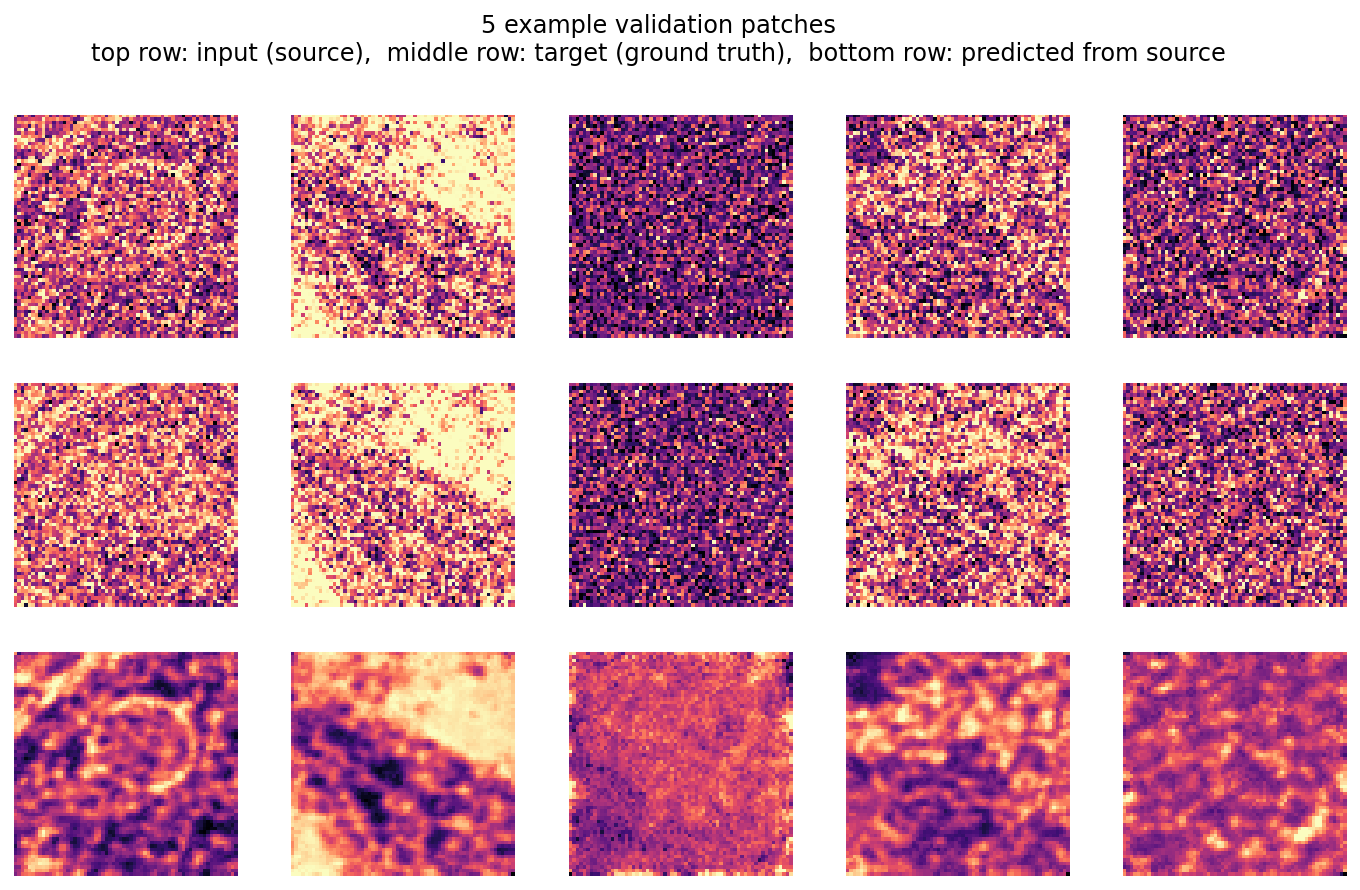

In [8]:
plt.figure(figsize=(12,7))
_P = model.keras_model.predict(X_val[:5])
if config.probabilistic:
    _P = _P[...,:(_P.shape[-1]//2)]
plot_some(X_val[:5],Y_val[:5],_P,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: target (ground truth),  '
             'bottom row: predicted from source');

<hr style="height:2px;">

# Export model to be used with CSBDeep **Fiji** plugins and **KNIME** workflows

See https://github.com/CSBDeep/CSBDeep_website/wiki/Your-Model-in-Fiji for details.

In [9]:
model.export_TF()

2022-07-19 17:05:53.468384: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 17:05:53.468559: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:01.0 name: NVIDIA A40-16Q computeCapability: 8.6
coreClock: 1.74GHz coreCount: 84 deviceMemorySize: 15.82GiB deviceMemoryBandwidth: 648.29GiB/s
2022-07-19 17:05:53.468636: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 17:05:53.468799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 17:05:53.468934: I tensorflow/core/common_runtime

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/tmph2rns4fh/model/saved_model.pb

Model exported in TensorFlow's SavedModel format:
/home/mattia.toninelli/DL4MIA/02_image_restoration/models/my_model_n2n/TF_SavedModel.zip
